# Logistic Regression and Classification

logistic regression is a type of regression that predicts a probability of an outcome given one or more independent variables. This in turn can be used for classification, which is predicting categories rather than real numbers as we did with linear regression.

We are not always interested in representing variables as continuous, where they can represent an infinite number of real decimal values. There are situations where we would rather variables be discrete, or representative of whole numbers, integers, or booleans (1/0, true/false). Logistic regression is trained on an output variable that is discrete (a binary 1 or 0) or a categorical number (which is a whole number). It does output a continuous variable in the form of probability, but that can be converted into a discrete value with a threshold.

**Understanding logistic Regression**

Imagine there was a small industrial accident and you are trying to understand the
impact of chemical exposure. You have 11 patients who were exposed for differing
numbers of hours to this chemical. Some have shown symptoms (value of 1) and others have not shown symptoms.

<img src="images/LogisticRegression_understanding.png" height="300px">

Doing a cursory analysis on this sample, we can say that there is nearly 0% probability a patient exposed for fewer than four hours will show symptoms, but there is 100% probability for greater than four hours. Between these two groups, there is an immediate jump to showing symptoms at approximately four hours.

Of course, nothing is ever this clear-cut in the real world. Let’s say you gathered more data, where the middle of the range has a mix of patients showing symptoms versus not showing symptoms

<img src="images/LogisticRegression_understanding_1.png" height="250px">

Because of this overlap of points in the middle, there is no distinct cutoff when
patients show symptoms but rather a gradual transition from 0% probability to 100%
probability (0 and 1). This example demonstrates how a logistic regression results in a curve indicating a probability of belonging to the true category (a patient showed symptoms) across an independent variable (hours of exposure).



#### Logistic Function

The logistic function is an S-shaped curve (also known as a sigmoid curve) that, for a given set of input variables, produces an output variable between 0 and 1. Because the output variable is between 0 and 1 it can be used to represent a probability

Probability y for one input variable x:
$$ y = \frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x)}} $$

The exponent  looks identical to $y = mx + b$ or $y = \beta_0 + \beta_1 x$.
This linear function in the exponent is known as the log-odds function, but for now just know this whole logistic function produces this S-shaped curve we need to output a shifting probability across an x-value.


In [ ]:
import math

def predict_probability(x, b0, b1):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

In [1]:
# Lets plot to see what it looks like and assumg 
# b0=-2.823 and 
# b1= 0.62

from sympy import *

b0, b1, x = symbols('b0 b1 x')

p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))

p = p.subs(b0,-2.823).subs(b1, 0.62)
print(p)

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


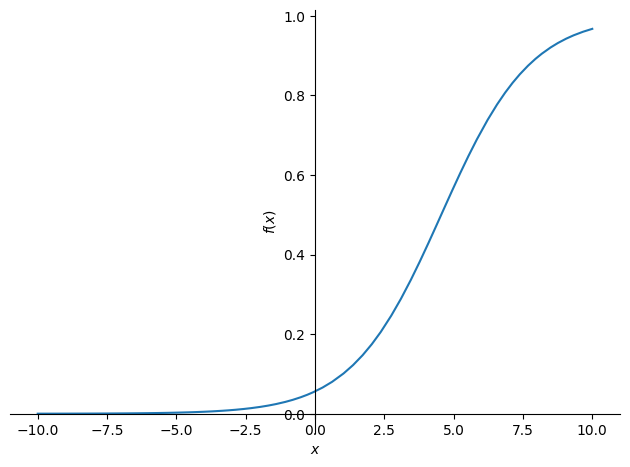

In [2]:
plot(p)

We can also extend logistic regression to more than one input variable (x1, x2, ... xn).
$$ y = \frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}} $$

### Fitting the logistic Curve

The data can have any mix of decimal, integer, and binary variables, but the output variable must be binary (0 or 1). When we actually do prediction, the output variable will be between 0 and 1, resembling a probability.

The data provides our input and output variable values, but we need to solve for the $β_0$ and $β_1$ coefficients to fit our logistic function. Instead of inizing **least squares**, we use **maximum likelihood estimation**, which, as the name suggests, maximizes the likelihood a given logistic curve would output the observed data.

In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load the data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",")

# Extract input variables (all rows, all columns but last column)
X = df.values[:, :-1]

# Extract output column (all rows, last column)
Y = df.values[:, -1]

# Perform logistic regression
# Turn off penalty
model = LogisticRegression(penalty=None)

model.fit(X, Y)

# print beta1
print(model.coef_.flatten()) 

# print beta0
print(model.intercept_.flatten()) 

[0.69267212]
[-3.17576395]


To make specific predictions, use the predict() and predict_prob() functions on
the model object in SciPy, whether it is a LogisticRegression or any other type of
classification model. The predict() function will predict a specific class (e.g., True 1.0 or False 1.0) while the predict_prob() will output probabilities for each class

### Using Maximum likelihood and Gradient Descent

Given coefficients β0 = –3.17576395 and β1 = 0.69267212, below code shows how we
calculate the joint likelihood for this data in Python.

In [5]:
import math
import pandas as pd

patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()
b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
    return p

# Calculate the joint likelihood
joint_likelihood = 1.0
for p in patient_data:
    if p.y == 1.0:
        joint_likelihood *= logistic_function(p.x)
    elif p.y == 0.0:
        joint_likelihood *= (1.0 - logistic_function(p.x))

print(joint_likelihood)

4.7911180221699105e-05


We can compress this `if` statement , mathematically it looks like this

$$ \text{joint likelihood} = \prod_{i=1}^{n} \left(\frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x_i)}}\right)^{y_i} \text{x}\ \left(\frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x_i)}}\right)^{1.0-y_i} $$

In [11]:
joint_likelihood=1.0

for p in patient_data:
    joint_likelihood *= logistic_function(p.x) ** p.y * \
        (1.0 - logistic_function(p.x)) ** (1.0 - p.y)

print(joint_likelihood)

1.0


WHAT 1.0 ??? WHY ?
Note that computers can get overwhelmed multiplying several small decimals
together, known as floating point underflow. There is a clever mathematical hack to get around this. You can take the `log()` of each decimal you are multiplying and instead add them together. and you can then call the `exp()` function to convert the total sum back to get the product

In [15]:
patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",").itertuples()
b0 = -3.17576395
b1 = 0.69267212

# Calculate the joint likelihood
joint_likelihood = 0.0

for p in patient_data:
    joint_likelihood += math.log(logistic_function(p.x) ** p.y * \
        (1.0 - logistic_function(p.x)) ** (1.0 - p.y))

joint_likelihood = math.exp(joint_likelihood)
print(joint_likelihood)

4.791118022169896e-05


So let’s just allow SymPy to do the partial derivatives for us, for $β_0$ and $β_1$ respectively. We will then immediately compile and use them for gradient descent,

In [16]:
# expressing the same in SymPy

from sympy import *
import pandas as pd
points = list(pd.read_csv("https://tinyurl.com/y2cocoo7").itertuples())
b1, b0, i, n = symbols('b1 b0 i n')
x, y = symbols('x y', cls=Function)

joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b0 + b1 * x(i))))) ** y(i) \
* (1.0 - (1.0 / (1.0 + exp(-(b0 + b1 * x(i)))))) ** (1 - y(i))), (i, 0, n))

# Partial derivative for m, with points substituted
d_b1 = diff(joint_likelihood, b1) \
        .subs(n, len(points) - 1).doit() \
            .replace(x, lambda i: points[i].x) \
                .replace(y, lambda i: points[i].y)

# Partial derivative for m, with points substituted
d_b0 = diff(joint_likelihood, b0) \
        .subs(n, len(points) - 1).doit() \
            .replace(x, lambda i: points[i].x) \
                .replace(y, lambda i: points[i].y)

# compile using lambdify for faster computation
d_b1 = lambdify([b1, b0], d_b1)
d_b0 = lambdify([b1, b0], d_b0)

# Perform Gradient Descent
b1 = 0.01
b0 = 0.01
L = .01

for j in range(10_000):
    b1 += d_b1(b1, b0) * L
    b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370813 -3.1757515504098213


### Multivariable Logistic Regression

| SEX | AGE | PROMOTIONS | YEARS_EMPLOYED | DID_QUIT |
|:---:|:---:|------------|----------------|----------|
| 1   | 32  | 3          | 7              | 0        |
| 1   | 34  | 2          | 5              | 0        |
| 1   | 29  | 2          | 5              | 1        |
| 0   | 42  | 4          | 10             | 0        |
| 1   | 43  | 4          | 10             | 0        |

$$ y = \frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}} $$


We will create βcoefficients for each of the variables sex, age, promotions, and
years_employed. The output variable did_quit is binary, and that is going to drive the logistic regression outcome we are predicting. Because we are dealing with multiple dimensions, it is going to be hard to visualize the curvy hyperplane that is our logistic curve. So we will steer clear from visualization

In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
employee_data = pd.read_csv("https://tinyurl.com/y6r7qjrp")

# grab independent variable columns
inputs = employee_data.iloc[:, :-1]

# grab dependent "did_quit" variable column
output = employee_data.iloc[:, -1]

# build logistic regression
fit = LogisticRegression(penalty='none').fit(inputs, output)

# Print coefficients:
print("COEFFICIENTS: {0}".format(fit.coef_.flatten()))
print("INTERCEPT: {0}".format(fit.intercept_.flatten()))

# Interact and test with new employee data
def predict_employee_will_stay(sex, age, promotions, years_employed):
    prediction = fit.predict([[sex, age, promotions, years_employed]])
    probabilities = fit.predict_proba([[sex, age, promotions, years_employed]])
    if prediction == [[1]]:
        return "WILL LEAVE: {0}".format(probabilities)
    else:
        return "WILL STAY: {0}".format(probabilities)

# Test a prediction
n = input("Predict employee will stay or leave {sex},{age},{promotions},{years_employed}: ")
(sex, age, promotions, years_employed) = n.split(",")
print(predict_employee_will_stay(int(sex), int(age), int(promotions), int(years_employed)))

c:\Users\manoj\Documents\MANOJ\Gitlab\math-for-data-science\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


COEFFICIENTS: [ 0.03213405  0.03682453 -2.50410028  0.9742266 ]
INTERCEPT: [-2.73485302]
WILL LEAVE: [[0.02918934 0.97081066]]


c:\Users\manoj\Documents\MANOJ\Gitlab\math-for-data-science\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\manoj\Documents\MANOJ\Gitlab\math-for-data-science\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


You will notice that the coefficients for sex, age, promotions, and years_employed
are displayed in that order. By the weight of the coefficients, you can see that sex and age play very little role in the prediction (they both have a weight near 0). However, promotions and years_employed have significant weights of –2.504 and 0.97. 

### Understanding the Log-Odds
It has always been a interest to mathematicians to take a linear function and scale its output to fall between 0 and 1, and therefore be useful for predicting probability. The log-odds, also called the logit function, lends itself to logistic regression for this purpose.


$$ y = \frac {1.0} {1.0 + e^{-(\beta_0 + \beta_1 x)}} $$

This linear function being raised to e is known as the log-odds function, which takes the logarithm of the odds for the event of interest. 

As an example, let’s use our logistic regression from earlier where Β0 = -3.17576395 and Β1 = 0.69267212. What is the probability of showing symptoms after six hours, where x = 6? 

$$ p = \frac {1.0} {1.0 + e^{-(-3.1757 + 0.6926 (6))}} = 0.727216 $$

$$ odds = \frac {p} {1-p} $$
$$ odds = \frac {0.72716} {1-0.72716} $$

So at six hours, a patient is 2.66517 times more likely to show symptoms than not
show symptoms. When we wrap the odds function in a natural logarithm (a logarithm with base e), we call this the logit function. The output of this formula is what we call the log-odds, named…shockingly…because we take the logarithm of the odds:

$$ logit = log \left(\frac {p} {1-p}\right) $$
$$ logit = log \left(\frac {0.72716} {1-0.72716}\right) = 0.98026 $$

Our log-odds at six hours is 0.9802687. What does this mean and why do we care?
When we are in “log-odds land” it is easier to compare one set of odds against
another. We treat anything greater than 0 as favoring odds an event will happen,
whereas anything less than 0 is against an event. A log-odds of –1.05 is linearly the same distance from 0 as 1.05. In plain odds, though, the equivalents are 0.3499 and 2.857, respectively, which is not as interpretable. That is the convenience of log-odds.

Recall I said the linear function in our logistic regression formula β0 + β1x is our log-odds function. Check this out:

log‐odds = β0 + β1x

log‐odds = − 3.17576395 + 0.69267212 6

log‐odds = 0.98026877

It’s the same value 0.98026877 as our previous calculation, the odds of our logistic regression at x = 6 and then taking the log() of it! So what is the link? What ties all this together? Given a probability from a logistic regression p and input variable x, it is this:

$$ log \left(\frac {p} {1-p}\right) = \beta_0 + \beta_1 x $$

<img src="images/LogisticRegression_logodds.png" height="250px"></a>

From the figure when the log-odds is 0.0 on the line, then the probability of the logistic curve is at 0.5. This makes sense because when our odds are fair at 1.0, the probability is going to be 0.50 as shown in the logistic regression, and the log-odds are going to be 0 as shown by the line.

Let’s first find the probabilities of symptoms for six hours and eight hours,
respectively

<img src="images/LogisticRegression_logodds_calc.png">

We get a value of approximately 3.996, meaning that our odds of showing symptoms increases by nearly a factor of four with an extra two hours of exposure: